*David Schlangen, 2019-03-20*

# Task: Computing Denotations

This notebook gives an overview of the image corpora that we have looked at so far. Many of these corpora have been used to create further annotation. Here, we only look at the corpora themselves -- that is, the types of images that can be found in them -- and the basic annotation that comes with them. Further annotations that we have looked at will be discussed in the notebooks in `03_Tasks`.

This notebook is part of a collection of notebooks. The series starts with `01_SemPics` and `02_ImageCorpora` (which should be read in that order) and continues with the notebooks in the current directory, `03_Tasks`, which can be read in any order.

## Introduction

Following the perspective explained in `01_SemPics`, this notebook here looks at tasks that can be conceptualised as requiring the computation of the value of the *denotation function*, $[\![\cdot]\!]$. More specifically, we will look into how we can use the expression/image relation that we find in the data, *annotates*, with that denotation relation (
$\mathcal{R}_{e/I} = \{ \mathit{annotates}, [\![\cdot]\!]\}$).

We will look at examples of pairs of expression and image objects roughly in order of increasing size and complexity. In the tradition of formal semantics, one would set this up in such a way that the output for more complex expressions is composed out of that for its constituents. We stay agnostic with respect to the actual details of the implementation, however.

What we do here is only to provide a *description* of the task and its inner structure; and to give some hints on how datasets could be constructed that make it possible to learn and evaluate models for it.

In [12]:
# imports

from __future__ import division
import codecs
import json
from itertools import chain, izip, permutations, combinations
from collections import Counter, defaultdict
import ConfigParser
import os
import random
from textwrap import fill
import scipy
import sys
from copy import deepcopy

from nltk.parse import CoreNLPParser
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import Latex, display

pd.set_option('max_colwidth', 250)

In [13]:
# Load up config file (needs path; adapt env var if necessary); local imports

# load config file, set up paths, make project-specific imports
config_path = os.environ.get('VISCONF')
if not config_path:
    # try default location, if not in environment
    default_path_to_config = '../Config/default.cfg'
    if os.path.isfile(default_path_to_config):
        config_path = default_path_to_config

assert config_path is not None, 'You need to specify the path to the config file via environment variable VISCONF.'        

config = ConfigParser.SafeConfigParser()
with codecs.open(config_path, 'r', encoding='utf-8') as f:
    config.readfp(f)

corpora_base = config.get('DEFAULT', 'corpora_base')
preproc_path = config.get('DSGV-PATHS', 'preproc_path')
dsgv_home = config.get('DSGV-PATHS', 'dsgv_home')


sys.path.append(dsgv_home + '/Utils')
from utils import icorpus_code, plot_labelled_bb, get_image_filename, query_by_id
from utils import plot_img_cropped, plot_img_ax, invert_dict, get_a_by_b
sys.path.append(dsgv_home + '/WACs/WAC_Utils')
from wac_utils import create_word2den, is_relational
sys.path.append(dsgv_home + '/Preproc')
from sim_preproc import load_imsim, n_most_sim

sys.path.append('../Common')
from data_utils import load_dfs, plot_rel_by_relid, get_obj_bb, compute_distance_objs
from data_utils import get_obj_key, compute_relpos_relargs_row, get_all_predicate
from data_utils import compute_distance_relargs_row, get_rel_type, get_rel_instances
from data_utils import compute_obj_sizes_row

In [14]:
# Load up preprocessed DataFrames. Slow!
# These DataFrames are the result of pre-processing the original corpus data,
# as per dsg-vision/Preprocessing/preproc.py

df_names = ['saiapr_bbdf', 'saiapr_refdf',
            'mscoco_bbdf', 'cococapdf', 'mscoco_catsdf',
            'refcoco_refdf', 'refcocoplus_refdf', 'grex_refdf',
            'vgregdf', 'vgimgdf', 'vgobjdf', 'vgreldf',
            'vgattdf', 'vgvqadf', 'vgpardf', 
            'flickr_bbdf', 'flickr_capdf', 'flickr_objdf']
df = load_dfs(preproc_path, df_names)

# a derived DF, containing only those region descriptions which I was able to resolve
df['vgpregdf'] = df['vgregdf'][df['vgregdf']['pphrase'].notnull() & 
                               (df['vgregdf']['pphrase'] != '')]

# easier to look up:
cococat = dict(zip(df['mscoco_catsdf'].index, df['mscoco_catsdf']['cat'].values))


# load up pre-computed similarities
coco_sem_sim, coco_sem_map = load_imsim(os.path.join(preproc_path, 'mscoco_sim.npz'))
visg_sem_sim, visg_sem_map = load_imsim(os.path.join(preproc_path, 'visgen_sim.npz'))
coco_id2semsim = invert_dict(coco_sem_map)
visg_id2semsim = invert_dict(visg_sem_map)

coco_vis_sim, coco_vis_map = load_imsim(os.path.join(preproc_path, 'mscoco_vis_sim.npz'))
visg_vis_sim, visg_vis_map = load_imsim(os.path.join(preproc_path, 'visgen_vis_sim.npz'))
coco_id2vissim = invert_dict(coco_vis_map)
visg_id2vissim = invert_dict(visg_vis_map)

As a reminder, this is where we left things. Here is one of the example images again, with information about the locations of objects overlayed on top of the image. The objects are identified with numerical identifiers. We said that we can see this information as constituting one part of a semantic model, the *domain* $D$, with the elements of that set being image patches, and that we can read from the additional annotation, among other things, the implied interpretation for the word *woman*.

<IPython.core.display.Latex object>

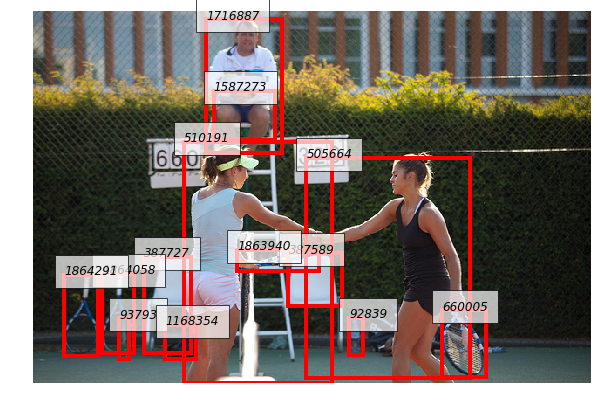

In [15]:
# load up one image from MSCOCO & overlay its bounding boxes and object IDs.
pick_row = 100
ic, ii  = df['refcoco_refdf'].iloc[pick_row][['i_corpus', 'image_id']]

this_anno = query_by_id(df['mscoco_bbdf'], (ic, ii), column=['bb', 'region_id']).values

display(Latex("$D = \\{" + ', '.join(['o_{' + str(rg) + '}' for _, rg in this_anno]) + "\\}$"))

plot_labelled_bb(get_image_filename(config, ic, ii),
                 [(b, str(reg)) for b, reg in this_anno])

<IPython.core.display.Latex object>

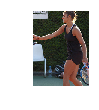

In [16]:
# show image patch corresponding to object

outcols = 'i_corpus image_id region_id refexp'.split()
combined = pd.concat([query_by_id(df['refcoco_refdf'], (ic, ii), column=outcols),
                      query_by_id(df['refcocoplus_refdf'], (ic, ii), column=outcols),
                      query_by_id(df['grex_refdf'], (ic, ii), column=outcols)])
i_woman = [r for c,i,r in create_word2den(combined)['woman']]

for this_obj in i_woman[:1]:
    this_bb = [int(e) for e in [e[0] for e in this_anno if e[1] == this_obj][0]]
    display(Latex('$o_{' + str(this_obj) + '} =$'))
    plot_img_cropped(get_image_filename(config, ic, ii), this_bb, width=1, height=2)

<IPython.core.display.Latex object>

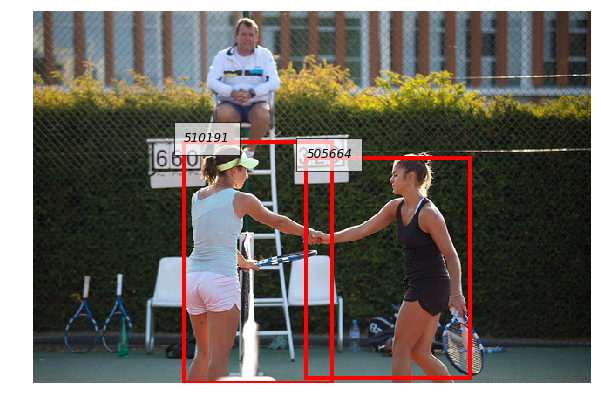

In [17]:
# get denotation of "woman" from referring expressions for this image

display(Latex('$I(woman) = \\{' + ', '.join(['o_{' + str(i) + '}' for i in i_woman]) + '\\}$'))
plot_labelled_bb(get_image_filename(config, ic, ii),
                 [(b, str(reg)) for b, reg in this_anno if reg in i_woman])

With this reconceptualisation of what the corpora give us, we can now see if we take the path from simple to complex expressions, and how they can be mapped into their denotations. The corpora give us ample material for this. The main task in the background will be that of *evaluating* the expression, given an image. We will also be interested in the question of whether how a model might *explain* the evaluation it provides. 

Some of the expressions that we will look at will be automatically extracted parts of longer expressions and as such cannot count as "real" attested examples of language use. Others however, will be in exactly the form as produced by the annotators of the original corpus. We will also touch on the question of whether such expression may tell us interesting things about the linguistic choices made by the annotators in the given context.

## Single Words

### Nouns

We'll start with an example of a type of annotation that is *not* as helpful as one might at first think. Asd described in the image corpus overview, the COCO corpus provides an annotation (typically, a single noun or a compositum) for each image object. Here is our example image, showing the bounding boxes with the annotation:

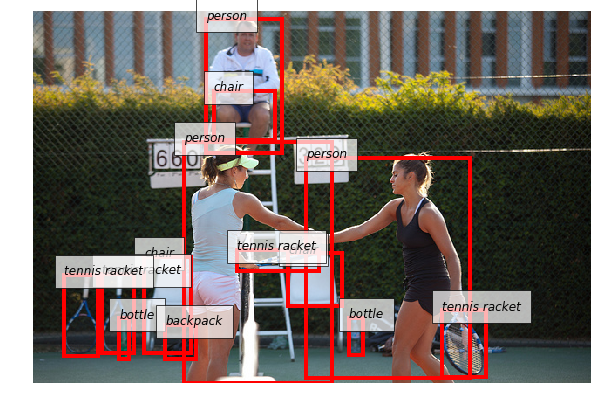

In [18]:
# plot mscoco categories on image
pick_row = 100
ic, ii  = df['refcoco_refdf'].iloc[pick_row][['i_corpus', 'image_id']]

this_anno = query_by_id(df['mscoco_bbdf'], (ic, ii), ['bb', 'cat']).values
plot_labelled_bb(get_image_filename(config, ic, ii),
                 [(b, cococat[cat]) for b, cat in this_anno])

We could now try to use this annotation to learn the interpretation function for these words, but unfortunately, we wouldn't get very far with this, as COCO uses a set of only 80 different categories. (And hence we would end up with a vocabulary of only this size.)

The "Visual Genome" corpus gives us a more fertile hunting ground. Here, the image objects are also annotated with single words (in the terminology of this corpus, their *names*), but instead of being taken from a pre-specified set of labels, these are taken from larger, freely-formulated expressions that were provided by annotators. (The "region descriptions" discussed in the corpus overview, and in more detail below.)

As the following numbers and diagrams show, there is a large number of types in this set of names, with a decently populated long tail (but note that this number will likely be inflated by typos and annotation artefacts):

Number of different noun word form types in visual genome: 105,724
Number of noun word form types of which there are at least 10 instances: 10,528
Number of different WordNet synsets in visual genome: 8,078
Number of noun WordNet synsets of which there are at least 10 instances: 3,488

Frequency distribution over types:


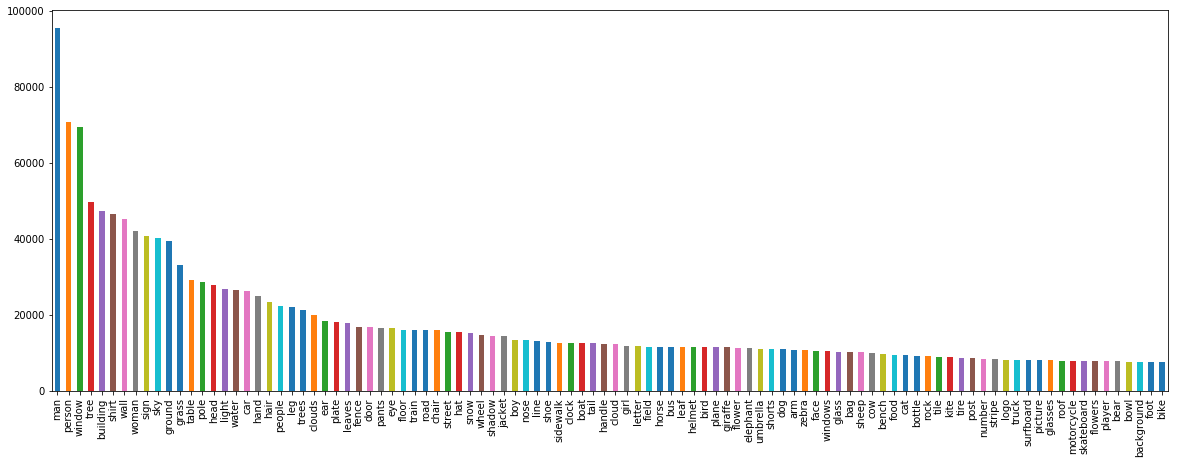

In [19]:
# compute number of noun types in visual genome & plot histogram
vgnames_vc = df['vgobjdf']['name'].value_counts()
print "Number of different noun word form types in visual genome: {:,}".format(len(vgnames_vc))
print "Number of noun word form types of which there are at least 10 instances: {:,}"\
    .format(len(vgnames_vc[vgnames_vc >= 10]))
vgsyns_vc = df['vgobjdf']['syn'].value_counts()
print "Number of different WordNet synsets in visual genome: {:,}".format(len(vgsyns_vc))
print "Number of noun WordNet synsets of which there are at least 10 instances: {:,}"\
    .format(len(vgsyns_vc[vgsyns_vc >= 10]))
print ''
print 'Frequency distribution over types:'
vgnames_vc[:100].plot(kind='bar', figsize=(20,7));

(If you squint your eyes and try to read the labels on the x-axis, you will also see that there is a certain bias in the data set: for example, the word "man" occurs more than twice as often as the word "woman".) 

Here is what this annotation looks like for one image from the corpus.

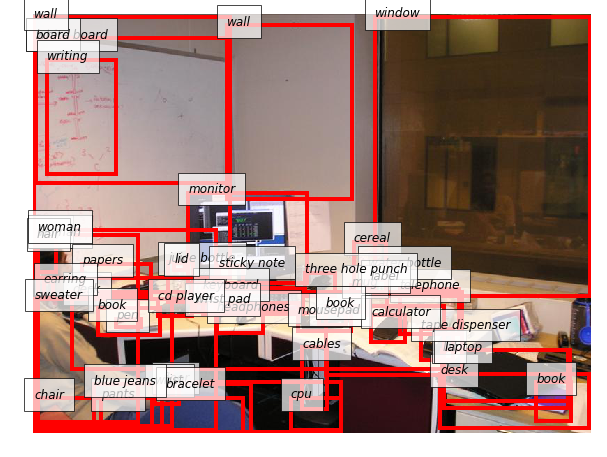

In [20]:
# plot all objects and names
pick_row = 262
this_row = df['vgobjdf'].iloc[pick_row]
ic, ii = this_row['i_corpus image_id'.split()].values

plot_labelled_bb(get_image_filename(config, ic, ii),
                 query_by_id(df['vgobjdf'], (ic, ii), ['bb', 'name']).values)

This annotation would already be useful to try to *learn* the interpretation for these words, as it gives us positive instances of word / image object pairings. For most learning methods, we would however also need to provide *negative* instances, where the pairing is not correct (in the sense that the image object does not depict an instance of what you would expect the word to denote). 

We have noted above (in `01_SemPics`) that in general, the corpora do *not* guarantee "naming exhaustivity", that is, that any object would be annotated with all names that might be appropriate for it. Think about it: Requiring this would make the task rather hard. A given object might be described correctly as "animal", or "dog", or "poodle"; in fact, it is an interesting question what the factors are that determine which of these categories is chosen in a given context. (We will discuss this in the notebook on the naming task.) 

Which means that simply selecting an object that was referred to in the annotation with a different name, and declaring it a negative instance for the word of interest, is somewhat dangerous. However, the same reasing as above tells us that the risk is perhaps manageable. Whatever governed the decision for the naming decision with respect to the object paired with the word of interest would be governing also the decisions for the other objects, and hence we can take the fact that another object was named differently as strong indication that it is indeed of a different category. Secondly, given that the images contain a large variety of objects, the likelihood is high that even a random pick of a different object would pick out one that is different.

We summarise the properties of the subcorpus that we could create from this as follows, in a schema that we will use from now on.

* **Dataset:** Nouns + image objects
* **Negative Instances:** Nouns + differently annotated image objects (negative sampling)
* **Source:** visual genome
* **Uses:** learn interpretation functions

### Adjectives 

Visual genome also provides attribute annotation (syntactically, typically adjectives) for objects (similarly taken from longer expressions). Here are the annotations for our example image, and some statistics about the attribute vocabulary:

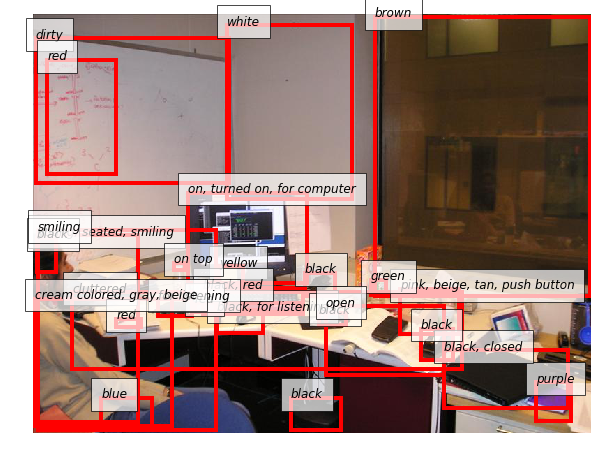

In [21]:
# and plot the attributes
plot_labelled_bb(get_image_filename(config, ic, ii),
    [(get_obj_bb(df['vgobjdf'], e[0]), ', '.join(e[1]))
     for e in query_by_id(df['vgattdf'], (ic, ii), ['obj_id', 'attributes']).values])

Number of different adjective types in visual genome: 80,258
Number of noun types of which there are at least 10 instances: 10,528

Frequency distribution over types:


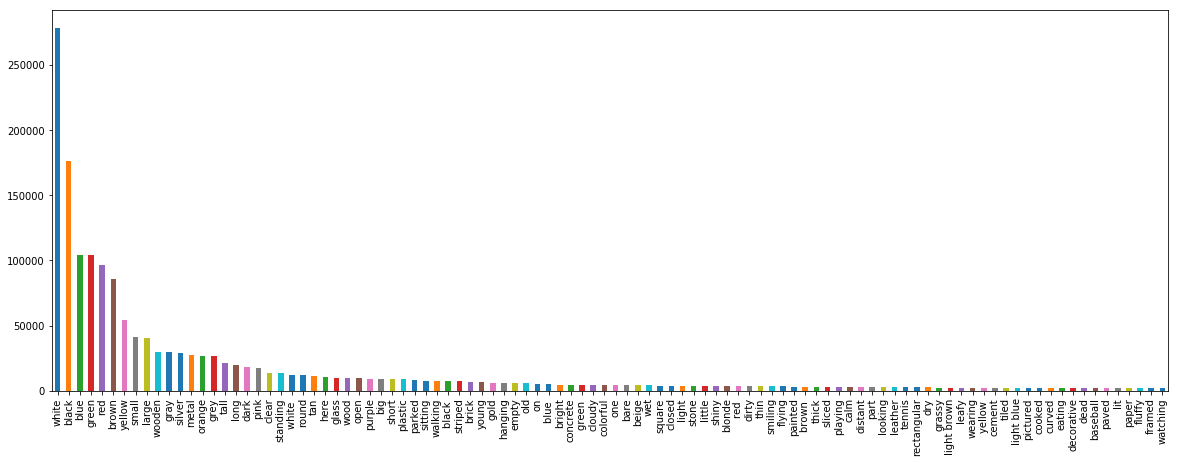

In [22]:
# some statistics about the attribute annotation
all_atts = [e for l in df['vgattdf']['attributes'].tolist() for e in l]
print "Number of different adjective types in visual genome: {:,}".format(len(set(all_atts)))

all_atts_cntr = Counter(all_atts)
print "Number of noun types of which there are at least 10 instances: {:,}"\
    .format(len(vgnames_vc[vgnames_vc >= 10]))

print ''
print 'Frequency distribution over types:'
pd.Series(all_atts).value_counts()[:100].plot(kind='bar', figsize=(20,7));

The distribution shows that colour terms are fairly well represented, and that there is a steep decline in the frequency of the less frequent types.

We should also note here that the *exhaustivity* assumption (which underlies the feasibility of negative sampling for negative instances) is potentially more doubtful here than for nouns. As we have just discussed, for nouns, we can assume that for a given object there is only a small range of appropriate names, and if an object is annotated at all, then an appropriate noun has a good chance of occurring. (Support for an argument like this could be taken from Rosch and colleagues's observation of the existence of "base-level categories" \cite{Rosch1978}.) Arguably, the range of appropriate adjectives / attributes is larger, and which one is used depends more on the context, so that there might be a higher chance that an attribute is mentioned for one object, but not for another, even if it would intuitively be appropriate. It would be interesting to test this hypothesis on this data set, but we will not do that here.

* **Dataset:** Adjectives + image objects
* **Negative Instances:** Adjectives + differently annotated image objects (negative sampling)
* **Source:** visual genome
* **Uses:** learn interpretation functions

## Simple NPs

As a next step, we can connect these bits of annotations to form simple NPs:

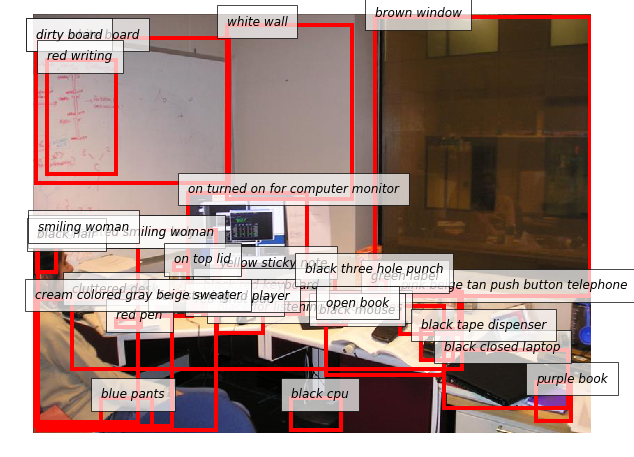

In [23]:
# plot attributes + names, for those objects for which attributes are available
bbs = []
for _, row in query_by_id(df['vgobjdf'], (ic, ii)).iterrows():
    this_atts = df['vgattdf'][df['vgattdf']['obj_id'] == row['obj_id']]['attributes'].values
    if len(this_atts):
        bbs.append((row['bb'], ' '.join(this_atts[0]) + ' ' + row['name']))

plot_labelled_bb(get_image_filename(config, ic, ii), bbs)

Assuming that we have learned the interpretation functions from the individual words as discussed in the previous section, what this then gives us is material for evaluating the *composition* of the denotations of the individual words into the denotation of the phrase. For example, the task would be to get from $[\![\ulcorner \textrm{red} \urcorner]\!]^I$ and $[\![\ulcorner \textrm{writing} \urcorner]\!]^I$ (with $\ulcorner \cdot \urcorner$ denoting the translation relation from expression to logical form, if we assume that there is such a layer) to $[\![\ulcorner \textrm{red writing} \urcorner]\!]^I$. 

In our own previous work \cite{schlaetal:imagewac}, we have explored the use of intersection on fuzzy sets; other methods might be possible as well. An interesting question that could be asked of the data is whether in this visual domain we ever encounter *non-intersective* adjectives (which would require a different way of composing denotations); we will not pursue this here.

* **Dataset:** simple NPs (ADJ + N)
* **Negative Instances:** negative sampling
* **Source:** derived from visual genome name and attribute annotation
* **Uses:** evaluate (or tune) composition function

## Definite NPs / Referring Expressions

The ReferIt corpora \cite{Kazemzadeh2014} \cite{yueatal:refcoco} give us expressions that were produced with the intention of referring to an individual object in a given image. Unlike the other types of expressions that we have available, they are taken from an actual, literal language game in which one player has the task to point out a pre-specified object to another player. The expressions are only recorded if the partner was then able to identify this image, and hence they are controlled for referential success. This makes the data  interesting from a *pragmatic* perspective as well, as, uniquely among the data we study here, in this setting the speaker had to make choices while clearly being oriented towards (aware of, and receiving success-feedback from) a specific addressee, in real-time. (RefCocoPlus added the constraint that the referred wasn't supposed to use positional information such as "in the left of the image".)

From a purely semantic perspective, we note that the expressions come with an assumption of *uniqueness*, as in order to perform their function, they must single out only one of the objects. This is typically seen as one semantic marker of definite reference. 

The uniqueness constraints is also met by the expressions from the GoogleREX corpus \cite{Maoetal:cocorefexp_Final}. This corpus is also described by the authors as collecting "referring expressions", but unlike the ReferIt data it was collected in a monological setting, and the expressions are better described as "unique descriptions". As we will see, the effect of the different pragmatic context (here, lack of real-time pressure and efficency constraints) is reflected in the form of these expressions.

Here as some examples of such "uniquely referring expressions", for the example image from above.

refcoco_refdf :
-  lady in black on right
-  girl in black
-  woman in black
refcocoplus_refdf :
-  black shirt
-  girl in black
-  player in black
grex_refdf :
-  woman in black tank top and shorts holding tennis racket
-  woman in black outfit shacking other tennis player hand


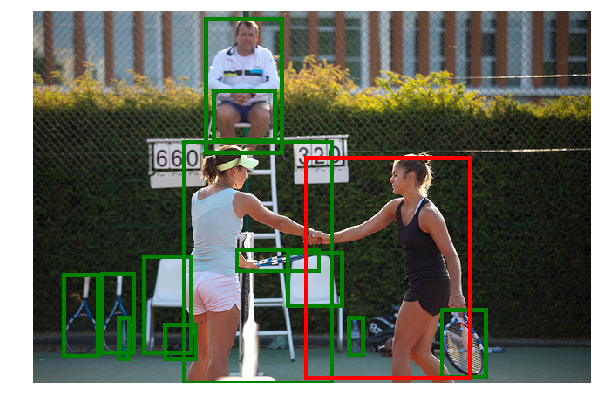

In [24]:
# show all refexps for a given region
pick_row = 100
ic, ii  = df['refcoco_refdf'].iloc[pick_row][['i_corpus', 'image_id']]

this_anno = query_by_id(df['mscoco_bbdf'], (ic, ii), ['bb', 'region_id']).values

pick_object = 4
ri = this_anno[pick_object][1]

for corp in ['refcoco_refdf', 'refcocoplus_refdf', 'grex_refdf']:
    print corp, ':'
    refexps = query_by_id(df[corp], (ic, ii, ri), 'refexp')
    for refexp in refexps:
        print '- ', refexp
    
bbs = [(bb[0], ('', 'green')) for bb in this_anno]
bbs.append((query_by_id(df['mscoco_bbdf'], (ic, ii, ri), 'bb')[0], ''))

plot_labelled_bb(get_image_filename(config, ic, ii), bbs)

This nicely demonstrates some properties of referring expressions in general, and also of the corpora. First we can note that the expressions are all longer than a single word. There is a good pragmatic reason for that: a category name such as "woman" would not have been enough here to single out the intended referent. For that, a further attribute must be mentioned. Here, for example, all expressions mention the colour of the woman's clothing. In the expressions from RefCoco, we additionally find a positional attribute ("on right"). (We won't find this in RefCocoPlus, because here annotators were explicitly discouraged from using positional information.)

The particulars of the ReferIt setting, where only pre-segmented objects could be selected for reference, may at least partially explain another phenomenon exemplified by one of the expressions shown below. There, "black shirt" is used to refer to the wearer as a whole (hence the rhetorical figure used here is synecdoche). It would be another interesting question to explore whether prior assumptions about base-level categories (and hence, about the thinks that one is likely to refer to) also influence the occurrence of this phenomenon.

Lastly, we note that GoogleRex expressions are the longest here, as they are on average in the whole corpus (see below). This is presumably a consequence of non-interactive setup, where efficiency is not such an issue, and effectiveness is not immediately checked.

To summarize, what these corpora give us are expressions of medium complexity (we will discuss a more complex sub-set below), which need to be resolved under the constraint that they should single out one object from a given domain.

* **Dataset:** referring expressions (mostly NPs)
* **Negative Instances:** negative sampling, from other objects in image (or from other images)
* **Source:** ReferIt, RefCoco, RefCoco+, GoogleRex
* **Uses:** evaluate (or tune) composition function; can also be used to learn interpretation function of constituent words

These corpora have been used in \cite{Kazemzadeh2014}, \cite{yueatal:refcoco}, \cite{Maoetal:cocorefexp_Final}, \cite{schlaetal:imagewac}, \cite{Cirik2018b} to train and test models of referring expression resolution.

We close the section with some statistics about the referring expression corpora, and about the average number of objects per image (which determines the difficulty of the resolution task).

In [25]:
# some statistics about available refexps
names_refdfs = ['saiapr_refdf', 'refcoco_refdf', 'refcocoplus_refdf', 'grex_refdf']
for name, size in zip(names_refdfs, map(len, [df[n] for n in names_refdfs])):
    avglen = df[name]['refexp'].str.split().apply(len).mean()
    print "{:>20}: {:>8,} refexps; avg. # words: {:.2f}".format(name, size, avglen)

print ''
print 'The average # of (bounding boxed) objects per image in MSCOCO: {:.2f}'.format(df['mscoco_bbdf'].groupby('image_id').size().mean())
print 'The average # of (bounding boxed) objects per image in visgen: {:.2f}'.format(df['vgobjdf'].groupby('image_id').size().mean())

        saiapr_refdf:  120,081 refexps; avg. # words: 3.43
       refcoco_refdf:  142,210 refexps; avg. # words: 3.50
   refcocoplus_refdf:  141,564 refexps; avg. # words: 3.53
          grex_refdf:   95,010 refexps; avg. # words: 8.31

The average # of (bounding boxed) objects per image in MSCOCO: 7.37
The average # of (bounding boxed) objects per image in visgen: 36.34


In [26]:
# some stats about vocabulary...
def get_vocab(inlist):
    tmp = ' '.join(inlist).split()
    return len(tmp), list(set(tmp))
def get_vocab_refdf(df):
    return get_vocab(df['refexp'].tolist())

vocab = {}
refexp_corps = ['saiapr_refdf', 'refcoco_refdf', 'refcocoplus_refdf', 'grex_refdf']
for this_corp in refexp_corps:
    n_tok, vocab[this_corp] = get_vocab_refdf(df[this_corp])
    print '{:>20}:    size vocab: {:>8,}  type/token: {:.4f} '.format(
        this_corp, len(vocab[this_corp]), len(vocab[this_corp]) / n_tok)
    
# TODO: intersection of all permutations, size of vocab

        saiapr_refdf:    size vocab:   10,058  type/token: 0.0244 
       refcoco_refdf:    size vocab:   10,341  type/token: 0.0208 
   refcocoplus_refdf:    size vocab:   12,226  type/token: 0.0245 
          grex_refdf:    size vocab:   13,945  type/token: 0.0177 


In [27]:
# vocab size of union of corpora
for this_set in list(chain.from_iterable(combinations(refexp_corps,r)
                                         for r in range(2,len(refexp_corps)+1))):
    print "vocab union of {:>47}: {:>8,}".format(', '.join(this_set),
                                                     len(set.union(*[set(vocab[e]) for e in this_set])))

vocab union of                     saiapr_refdf, refcoco_refdf:   16,774
vocab union of                 saiapr_refdf, refcocoplus_refdf:   18,394
vocab union of                        saiapr_refdf, grex_refdf:   19,984
vocab union of                refcoco_refdf, refcocoplus_refdf:   16,988
vocab union of                       refcoco_refdf, grex_refdf:   19,203
vocab union of                   refcocoplus_refdf, grex_refdf:   20,038
vocab union of  saiapr_refdf, refcoco_refdf, refcocoplus_refdf:   22,600
vocab union of         saiapr_refdf, refcoco_refdf, grex_refdf:   24,499
vocab union of     saiapr_refdf, refcocoplus_refdf, grex_refdf:   25,341
vocab union of    refcoco_refdf, refcocoplus_refdf, grex_refdf:   24,031
vocab union of saiapr_refdf, refcoco_refdf, refcocoplus_refdf, grex_refdf:   28,981


The examples that we have seen here were all relatively simple (if non-standard) NPs in that they only contain one noun. (Apart from the GoogleREX examples.) Further inspection of the referring expression corpora, however, shows that they contain a sizeable number of more complex expressions. We will look at these in the next section.

## Relational NPs / Prepositional Phrases

### ... in the referring expression corpora

Some of the referring expressions in the corpora work by relating the target referent to another object. We can filter out such utterances, using a list of prepositions like "below", "above", etc.:

In [28]:
# show some relational referring expressions from RefCoco
relmask = df['refcoco_refdf']['refexp'].apply(is_relational)
for refexp in df['refcoco_refdf'][relmask].head(10)['refexp'].tolist():
    print refexp

woman under suitcase
the head just behind the girl on leftin the middle
laptop above cellphone right
top right of image
black van in front of cab
clock next to womans left foot
blurred head left of the woman
right bike in between white shirt and black shirt
bowl behind the others can only see part
woman next to man


In [29]:
# proportion of relation expressions in refcoco:
print "proportion of relational expr. in refcoco: {:.3}%".format(
    relmask.sum() / len(df['refcoco_refdf']) * 100)

proportion of relational expr. in refcoco: 5.39%


(Before we move on, note the non-standard syntax (at least for writing) of some of the expressions, where articles are dropped; "black van in front of cab" instead of "*the* black van in front of *the* cab". This is presumably another effect of the setting which incentivises for efficiency.)

These constructions work by locating the *target object* via a *landmark object* (e.g., the *black van* via the *cab*, in "black van in front of cab"). To compute their denotation it is necessary to learn what the contribution of the relation is; for this, it is necessary to know the denotation not only of the expression as a whole, but also of the landmark individually. Unfortunately, this is not something that the corpora discussed so far give us. (\cite{Cirik2018b} provide this for a small part of GoogleREX.) For this, we need to turn to visual genome (and away from referring expressions).

* **Dataset:** relational referring expressions (NPs containing PPs)
* **Negative Instances:** negative sampling, from other objects in image (or from other images)
* **Source:** ReferIt, RefCoco, RefCoco+, GoogleRex
* **Uses:** learn interpretation function of relational expressions; evaluate (or tune) composition function. Caveat: not all arguments of relation resolved in corpus.

### ... fully resolved, from VisualGenome

The visual genome corpus was collected with the explicit purpose of providing material for learning "interactions and relationships between objects in an image" \cite{krishnavisualgenome}. The starting point of the annotation was the marking of a region of interest in the image, and the annotation of that region with a "region description", that is, an expression that is true of that region. (Note the difference to the referring expressions from the previous sections: Here, the descriptions are only meant to be true of the part of the image they describe, without making assumptions about other regions.)

Annotators were encouraged to provide region descriptions that are relational, and these then form the basis of an abstracted representation of that relation. The following shows some examples of region descriptions.

In [30]:
# some region descriptions from visual genome
df['vgregdf']['phrase'].head(10)

0            the clock is green in colour
1              shade is along the street 
2                 man is wearing sneakers
3                 cars headlights are off
4        bikes are parked at the far edge
5    A sign on the facade of the building
6            A tree trunk on the sidewalk
7                    A man in a red shirt
8      A brick sidewalk beside the street
9                 The back of a white car
Name: phrase, dtype: object

As these examples show, syntactically these descriptions are varied, sometimes being sentences ("man is wearing sneakers"), but more often being nominal phrases, and mostly indefinite ones. 

Let's look at one such description in more detail, showing first the original phrase as it was provided by the annotator, then the abstracted and normalised relation derived from it (as provided in the corpus; this can be seen as a "logical form" meaning representation of the sentence), then a representation that tries to align the object annotation back into the phrase (not in the original data set, derived automatically), and finally the image, with the related objects shown. The "logical form" of the expression links some elements of it to the WordNet ontology \cite{fellbaum:wordnet}.

The original phrase:
   Impressionist puzzle next to a computer monitor

The derived relation, resolved into roles, and with object IDs and normalised nouns and relation:
  "next to a":be.v.01( 1060704:puzzle.n.01 , 1060699:computer_monitor.n.01 )

The resolved entities aligned with the orignal phrase:
   Impressionist puzzle|1060704|puzzle.n.01 next to a computer monitor|1060699|computer_monitor.n.01

And finally, the image with the bounding boxes:


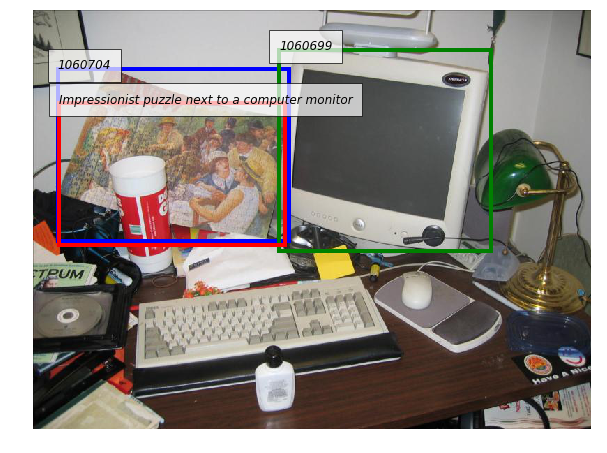

In [31]:
# showcase some of the annotations from visual genome, for one region
pick_row = 262
this_row = df['vgpregdf'].iloc[pick_row]
ic, ii, ri, rbb = this_row['i_corpus image_id region_id bb'.split()].values
rel_id = this_row['rel_ids'][0]
print 'The original phrase:\n  ', this_row['phrase']
print ''
print 'The derived relation, resolved into roles, and with object IDs and normalised nouns and relation:'
#display(df['vgreldf'][df['vgreldf']['rel_id'] == rel_id])
that_row = df['vgreldf'][df['vgreldf']['rel_id'] == rel_id]
print '  "{}":{}( {}:{} , {}:{} )'.format(that_row['predicate'].values[0],
                                      that_row['rel_syn'].values[0],
                                      that_row['sub_id'].values[0],
                                      that_row['sub_syn'].values[0],
                                      that_row['obj_id'].values[0],
                                      that_row['obj_syn'].values[0])
print ''
print 'The resolved entities aligned with the orignal phrase:\n  ', this_row['pphrase']
print ''
print 'And finally, the image with the bounding boxes:'
_, bbs = plot_rel_by_relid(df['vgreldf'], df['vgobjdf'], rel_id)
plot_labelled_bb(get_image_filename(config, ic, ii), bbs + [(rbb, this_row['phrase'])])

The corpus comes with a large number of relation annotations; however, the variety is somewhat limited. The following provides some statistics, using the WordNet normalisations from the corpus as the type labels for the relations. As this shows, the annotation is dominated by mostly positional relations ("along"), with a very long tail of infrequently occurring relations.

Number of annotated relations: 2,324,859
Number of relation types (synsets): 1,234
Number of relation types (synsets) with at least 10 instances: 561
Number of relation types (surface): 37,342
Number of relation types (surface) with at least 10 instances: 3127

The 10 most frequent ones:


along.r.01     560994
have.v.01      288965
be.v.01        204875
in.r.01        189497
wear.v.01      108774
behind.r.01     30563
about.r.07      23096
next.r.01       18939
sit.v.01        17953
under.r.01      14332
Name: rel_syn, dtype: int64


10 hapax legomena relation types:


scowl.v.01         1
effect.v.01        1
map.v.01           1
commandeer.v.01    1
knock.v.06         1
parade.v.01        1
dislike.v.01       1
gripe.v.01         1
nudge.v.01         1
review.v.03        1
Name: rel_syn, dtype: int64


Distribution of frequencies:


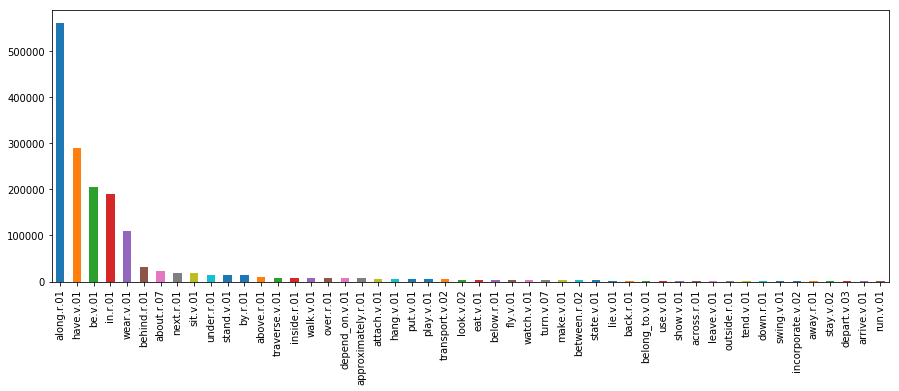

In [32]:
# compute some stats about the relation annotation; show histogram
print "Number of annotated relations: {:,}".format(len(df['vgreldf']))
vgreldf_valc = df['vgreldf']['rel_syn'].value_counts()
print "Number of relation types (synsets): {:,}".format(len(vgreldf_valc))
print "Number of relation types (synsets) with at least 10 instances:",\
    len([r for r,c in vgreldf_valc.items() if c >= 10])
vgreldf_pred_valc = df['vgreldf']['predicate'].value_counts()
print "Number of relation types (surface): {:,}".format(len(vgreldf_pred_valc))
print "Number of relation types (surface) with at least 10 instances:",\
    len([r for r,c in vgreldf_pred_valc.items() if c >= 10])

print ""
print "The 10 most frequent ones:"
display(df['vgreldf']['rel_syn'].value_counts()[:10])
print ""
print "10 hapax legomena relation types:"
display(df['vgreldf']['rel_syn'].value_counts()[-10:])

print ""
print "Distribution of frequencies:"
df['vgreldf']['rel_syn'].value_counts()[:50].plot(kind='bar', figsize=(15,5));

What can we do with this data? First of all, we can (relatively) straightforwardly use it to learn the (visual) meaning of the relational elements. (Relatively straightforward, because "logical form" is not fully aligned to the originating phrase, and we hence need to do some work to identify the relation-denoting parts and the entity-denoting parts.)

Since we would  want the interpretation of such an relational item to be a set of pairs, we need to provide positive examples of pairs that are in the relation in question, and pairs that aren't. A question arises now about what the best *negative* examples would be when learning a relation. A first approach could be to sample from all other relations annotated for the same image. The following does this for our example ("puzzle next to a computer"):

<!--(This is regardless of whether or not we will later curry the binary relation [i.e., turn it into a unary function from entities to functions from entities to truth values]; that is a matter of application, not of what the denotation is.)-->

sampled as negative examples for target relation:
  computer.n.01|5345 IN picture.n.01|5346
  bottle.n.01|1060708 has cap.n.01|1060734
  1060715 has a 1060716
  1060722 ON 1060700


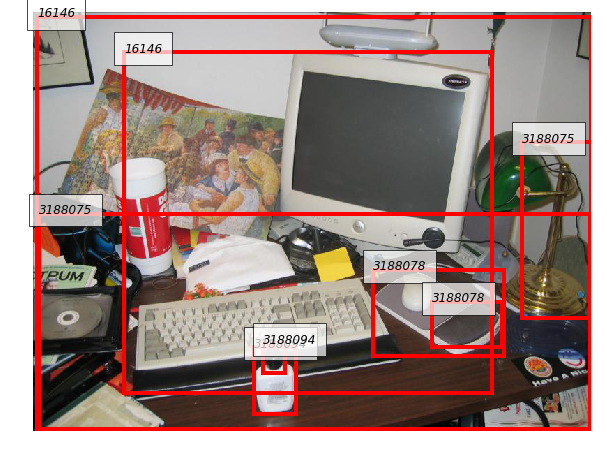

In [33]:
# all other annotated relations as pool for sampling negative examples
n_neg = 4 # number of negatives to sample
target_predicate = that_row['predicate'].values[0]
all_rels_this_image = query_by_id(df['vgreldf'], (ic, ii))
positive = all_rels_this_image[all_rels_this_image['predicate'] == target_predicate]
negative = all_rels_this_image[all_rels_this_image['predicate'] != target_predicate]
bbs = []
print "sampled as negative examples for target relation:"
for _, row in negative.sample(n_neg).iterrows():
    rel_id = row['rel_id']
    if row['sub_syn'] and row['sub_syn'] and row['obj_syn']: 
        print " ", row['sub_syn'] + '|' + str(row['sub_id']), row['predicate'], \
                    row['obj_syn'] + '|' + str(row['obj_id'])
    else:
        print " ", str(row['sub_id']), row['predicate'], str(row['obj_id'])        
    bbs.extend([(get_obj_bb(df['vgobjdf'], row['sub_id']), str(rel_id)),
                (get_obj_bb(df['vgobjdf'], row['obj_id']), str(rel_id))])
plot_labelled_bb(get_image_filename(config, ic, ii), bbs)

On second thought, this might not be the best strategy. First, the jump from "not annotated for" to "does not hold" seems even more daring here. A relation like "next to" might intuitively also hold in many cases where only other relations, such as "behind" have been annotated. (That is, there is arguably more semantic overlap between relations than there is between categories denoted by nouns.)

Second, such a strategy seems to oversample pairs that are close to each other (because these will tend to be annotated for relations). What the best strategy is is ultimately an empirical question which we cannot resolve here. In any case, here is a look at an alternative strategy applied to the same scene, which randomly samples from all *possible* pairs of objects. This at least seems to achieve a broader coverage of distances. (Boxes labelled with the same number would be candidates for being related to each other.)

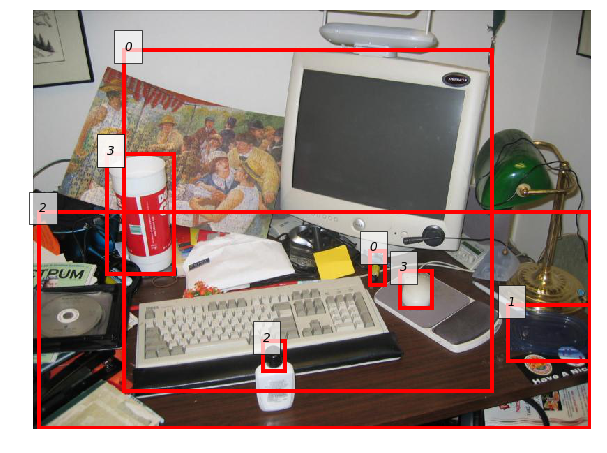

In [34]:
# whole set of pairs of objects from scene, incl. those for which no rel is annotated
target_predicate = that_row['predicate'].values[0]
all_rels_this_image = query_by_id(df['vgreldf'], (ic, ii))
positive = all_rels_this_image[all_rels_this_image['predicate'] == target_predicate]
positive_pairs = positive['sub_id obj_id'.split()].values

all_obj_this_image = list(set(query_by_id(df['vgobjdf'], (ic, ii), 'obj_id')))
all_pos_pairs = [tuple(p) for p in positive_pairs]
all_neg_pairs = [e for e in permutations(all_obj_this_image, 2) 
                 if e not in all_pos_pairs]
neg_indices = np.random.choice(range(len(all_neg_pairs)), n_neg, replace=False)
negatives = np.array(all_neg_pairs)[neg_indices]
bbs = []
for n, row in enumerate(negatives):
    bbs.extend([(get_obj_bb(df['vgobjdf'], row[0]), str(n)),
                (get_obj_bb(df['vgobjdf'], row[1]), str(n))])
plot_labelled_bb(get_image_filename(config, ic, ii), bbs)

* **Dataset:** relational expressions (NPs containing PPs, Ss containing transitive VPs)
* **Negative Instances:** negative sampling of pairs of objects
* **Source:** visual genome
* **Uses:** learn interpretation function of relational expressions; evaluate (or tune) composition function.

We can also ask what exactly the relational classifiers need to "see". Do they need to take the structure of the relata themselves into account (that is, do the need to get the full visual feature representation of the objects), or might it be enough to look at their relative positioning? This is a question that can be related to a long-standing issue in psycholinguistics, and hence we take a brief excursus to look at what our data might tell us about that.

### Excursus: Spatial Language in the Corpora

There is long-standing interest in cognitive science and psycholinguistics in the phenomenon of *spatial language* (language that locates objects and regions in spaces), as this is a domain where language very observably maps onto non-linguistic representations. 

In a classic paper, Landau and Jackendoff \cite{landau_jackendoff_1993} claimed that spatial relations only represent "coarse geometric properties, primarily the main axes", and, crucially for our discussion here, that they do not look into geometric properties like shape etc. of the related objects. That is, while the related nouns take care of the "what", the spatial prepositions take only care of the "where"  and make no further demands on their relata. (The "what" and "where" of title of that paper alluding to the then newly proposed and widely discussed distinction between the "what" and "where" visual systems \cite{ventraldorsal:whatwhere}.)
<!-- The proposal was later revised somewhat by Landau \cite{Landau2016}, who observes that some prepositions such as *in* and *on* "engage force-dynamic, functional relationships", while others such as *above/below*, *right/left* "engage geometry" in their "core meanings". -->

We will not delve deeply into these questions here, but just try to make plausible that the data we have available might be useful for approaching them.

One thing we can do with the annotation is to look at the relative positioning of the bounding boxes of the objects occuring in the relations in visual genomens.  

The following plots the position of the target object (e.g., "the woman" in "the woman to the left of the machine") relative to the landmark object ("the machine", in that example). As this shows, the relations in general roughly seem to place the expected constraints on the relative positioning (e.g., "above" vs. "below"), but without further information it is likely difficult to distinguish between some of the classes (e.g., "in" vs "on", or "in front of" vs "behind").

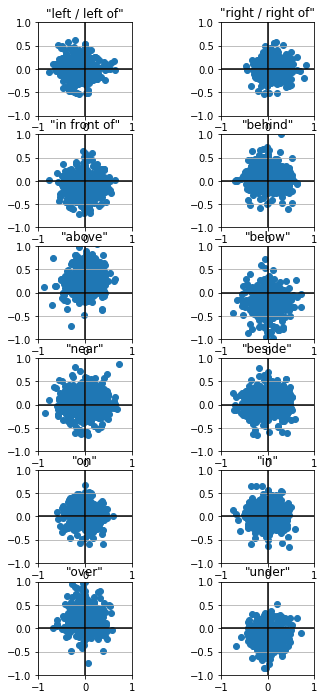

In [35]:
# plot relative positions of subj & object of rel, for some prepositions. V. SLOW!

n_samples = 1000

relations = [
    ['left', 'left of'],
    ['right', 'right of'],
    ['in front of'],
    ['behind'],
    ['above'],
    ['below'],
    ['near'],
    ['beside'],
    ['on'],
    ['in'],
    ['over'],
    ['under']
]

relfunc = lambda x: compute_relpos_relargs_row(df['vgimgdf'], df['vgobjdf'], x)

n_cols = 2
n_rows = len(relations) // n_cols + (len(relations) % n_cols > 0)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 2 * n_rows))

for n, this_pred in enumerate(relations):
    this_sample = get_all_predicate(df['vgreldf'], this_pred)

    if len(this_sample) > n_samples:
        this_sample = this_sample.sample(n_samples)

    rp = this_sample.apply(relfunc, axis=1)

    this_ax_x = n // n_cols
    this_ax_y = n % n_cols
    ax[this_ax_x, this_ax_y].scatter([x for x,_ in rp], [y for _,y in rp])
    ax[this_ax_x, this_ax_y].grid(True, which='both')
    ax[this_ax_x, this_ax_y].set_aspect('equal')
    ax[this_ax_x, this_ax_y].set_ylim(-1,1)
    ax[this_ax_x, this_ax_y].set_xlim(-1,1)
    ax[this_ax_x, this_ax_y].axhline(y=0, color='k')
    ax[this_ax_x, this_ax_y].axvline(x=0, color='k')
    ax[this_ax_x, this_ax_y].set_title('"{}"'.format(' / '.join(this_pred)))

Zooming in on one particular opposition and on the nature of the relata themselves,  the following graph shows the number of instances of the pattern "in X" vs "on X" for 100 randomly selected object synsets. (Note that the x-axis is in log-scale.) As this shows, while for many concepts there seems to be a preference to be either something that something else can be "in" or "on", there does not seem to be strict exclusivity, and many objects can be argument of either relation.

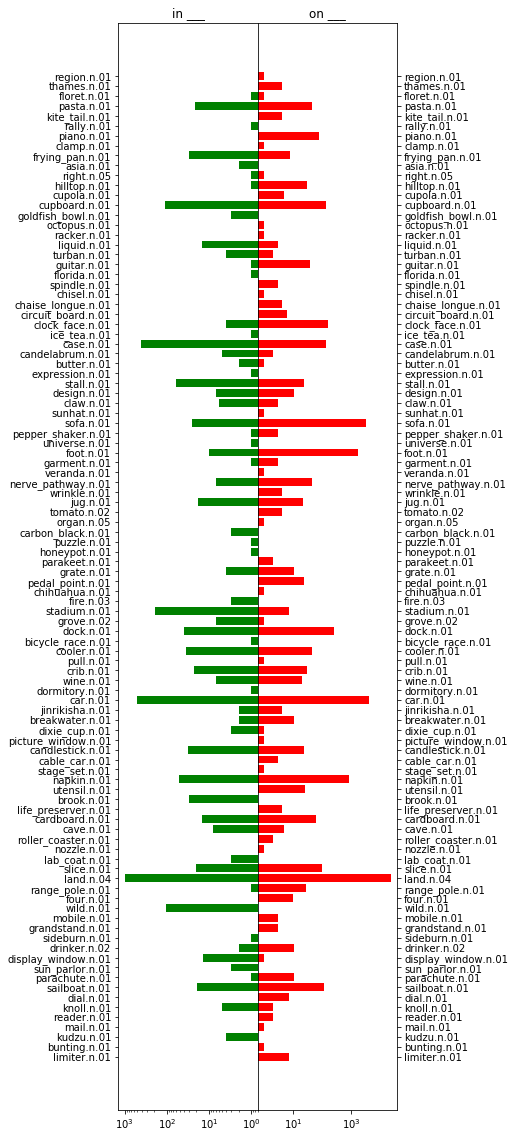

In [36]:
# 100 random things that can be object of "in" or "on"
in_things = df['vgreldf'][df['vgreldf']['predicate'].str.lower() == 'in']['obj_syn'].tolist()
on_things = df['vgreldf'][df['vgreldf']['predicate'].str.lower() == 'on']['obj_syn'].tolist()

sin_things = set(in_things)
son_things = set(on_things)
in_things_counter = Counter(in_things)
on_things_counter = Counter(on_things)

vocab = sorted(list(set.union(sin_things, son_things) - {None}))

n_max = 100
vocab_sample = np.random.choice(vocab, n_max, replace=False)

fig, axes = plt.subplots(ncols=2, figsize=(5,20)) # , sharey=True)

for y, word in enumerate(vocab_sample):
    axes[0].barh(y, in_things_counter[word], align='center', color='green')
    axes[1].barh(y, on_things_counter[word], align='center', color='red')
    #print word, in_things_counter[word], on_things_counter[word]
        
axes[0].invert_xaxis()
axes[0].set_xscale("log")
axes[1].set_xscale("log")

axes[0].set(yticks=range(n_max), yticklabels=vocab_sample)
axes[1].set(yticks=range(n_max), yticklabels=vocab_sample)
axes[1].yaxis.tick_right()

axes[0].set_title('in ___')
axes[1].set_title('on ___')
plt.subplots_adjust(wspace=0, hspace=0)

We close this brief look into the relations with a look at the appearance of the objects that fill either subject (target) or object (landmark) position. \cite{milljohns:langperc} noted that in cases where the related objects are unequal in size, then it typically is the landmark object which is the larger one. Our data seem to bear this out, if only just, as the ratio between the sizes and the following plot of the sizes of the bounding boxes of the objects in subject role of the relation and of those in object role shows. (This is the relevant metric; the boxplots only underline this, but they average over the targets and landmarks separately.)

Avg. ratio size landmark / size target: 1.88


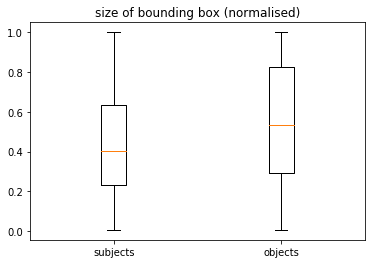

In [37]:
# compare (normalised) sizes of subject and object bounding boxes
this_sample = df['vgreldf'].sample(5000)
sizfunc = lambda x: compute_obj_sizes_row(df['vgimgdf'], df['vgobjdf'], x)
sizes = this_sample.apply(sizfunc, axis=1)

print "Avg. ratio size landmark / size target: {:.2f}".format(
    np.array([(b / a) for a, b in sizes]).mean()
)

plt.boxplot([[x for x,_ in sizes], [y for _,y in sizes]],
            labels=['subjects', 'objects']);
plt.title('size of bounding box (normalised)');

## Plural NPs, Quantified NPs

The Visual Genome annotation also resolves some NPs to more than one object. Here is an example (from visual genome) where "desktop computers" is resolved to four separate instances of the type "desktop computer":

[u'the are desktop computers on the desk'
 u'the are desktop computers|5455|desktop_computer.n.01|5456|desktop_computer.n.01|5457|desktop_computer.n.01|5458|desktop_computer.n.01 on the desk|1060961|desk.n.01']
[5 19 u'along.r.01' u'ON' 16251 u'desktop_computer.n.01' 5455 u'desk.n.01'
 1060961]
[5 19 u'along.r.01' u'ON' 16252 u'desktop_computer.n.01' 5456 u'desk.n.01'
 1060961]
[5 19 u'along.r.01' u'ON' 16253 u'desktop_computer.n.01' 5457 u'desk.n.01'
 1060961]
[5 19 u'along.r.01' u'ON' 16254 u'desktop_computer.n.01' 5458 u'desk.n.01'
 1060961]


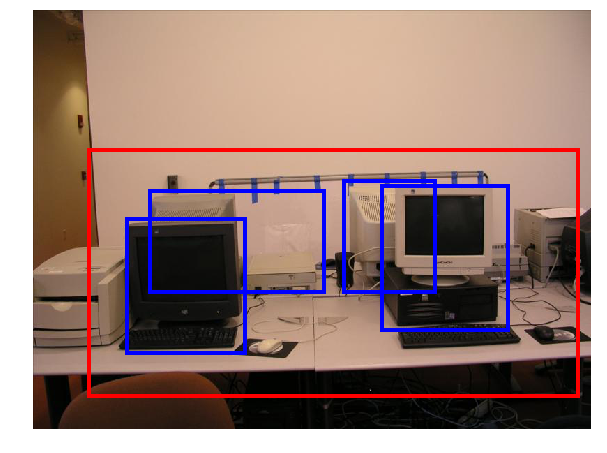

In [38]:
# there are desktop computers
reg_id = 4665
rel_id_a = 16251
rel_id_b = 16252
rel_id_c = 16253
rel_id_d = 16254


print df['vgpregdf'][df['vgpregdf']['region_id'] == reg_id][['phrase', 'pphrase']].values[0]
print df['vgreldf'][df['vgreldf']['rel_id'] == rel_id_a].values[0] 
print df['vgreldf'][df['vgreldf']['rel_id'] == rel_id_b].values[0]
print df['vgreldf'][df['vgreldf']['rel_id'] == rel_id_c].values[0] 
print df['vgreldf'][df['vgreldf']['rel_id'] == rel_id_d].values[0]


ic, ii, bb = df['vgpregdf'][df['vgpregdf']['region_id'] == reg_id]['i_corpus image_id bb'.split()].values[0]
obj_id_a = 5455
obj_id_b = 5456
obj_id_c = 5457
obj_id_d = 5458
bbs = [(bb, ''),
       (get_obj_bb(df['vgobjdf'], obj_id_a), ('', 'blue')),
       (get_obj_bb(df['vgobjdf'], obj_id_b), ('', 'blue')),
       (get_obj_bb(df['vgobjdf'], obj_id_c), ('', 'blue')),
       (get_obj_bb(df['vgobjdf'], obj_id_d), ('', 'blue')),
      ]
plot_labelled_bb(get_image_filename(config, ic, ii), bbs)

Cases like this could be used to learn the meaning of the plural morpheme (requiring that there is more than one), and of other items such as numerals. 

Here are some more examples. (Which also show that sometimes the plural denotation is spurious, caused by redundant object segmentations.)

**TODO:** This should be detected through a cleaning up of the object annotations; unify, if IoU is too large.

In [39]:
# Stats on groups as denotations; some examples
max_rows = 10000
plurals = [p for p in df['vgpregdf'][:max_rows][df['vgpregdf'][:max_rows]['pphrase']\
                                     .apply(lambda x: np.any(np.array([t.count('|') > 2 for t in x.split()])))]['pphrase'].tolist()\
     if 'and' not in p]
print "{:.2f}% of the region descriptions (in sample) are resolved to groups".format(len(plurals) / max_rows * 100)
print ""
print "Some examples:"
for pl in plurals[20:25]:
    print "  ", fill(pl, 80)
    print ''

6.78% of the region descriptions (in sample) are resolved to groups

Some examples:
   blue tape|1060922|tape.n.01|1060923|tape.n.01|5440|tape.n.01|5441|tape.n.01|1060
926|tape.n.01 stuck on the wall|1060942|wall.n.01

   the are desktop computers|5455|desktop_computer.n.01|5456|desktop_computer.n.01|
5457|desktop_computer.n.01|5458|desktop_computer.n.01 on the
desk|1060961|desk.n.01

   bookshelf|1061006|bookshelf.n.01|1060988|bookshelf.n.01|1060989|bookshelf.n.01
is made of woods|1061007|wood.n.01

   Cars|1061126|car.n.01|5499|car.n.01|5500|car.n.01|1061129|car.n.01 on a
street|1061094|street.n.01

   Shadows|5514|shadow.n.01|1061134|shadow.n.01 of palm
trees|5504|palm.n.03|1061119|palm.n.03 on the road|1061144|road.n.01



Filtering via the expressions rather than the denotations, we can find instances of other plural constructions. (However, they may not always be fully resolved in the corpus.)

In [40]:
# look at some other numerals & quantifiers
quantfs = 'several two three many'.split()
quant_inst = {}
for quantf in quantfs:
    quant_inst[quantf] = df['vgpregdf'][df['vgpregdf']['phrase'].str.contains(quantf)]
    print "-" * 50
    print "Instances of {:>8}: {:>6,}".format(quantf, len(quant_inst[quantf]))
    print "Examples:"
    for ex in quant_inst[quantf].sample(2)['pphrase'].tolist():
        print "    ", fill(ex, 70)

--------------------------------------------------
Instances of  several:  1,415
Examples:
     several windows|921225|window.n.01|921224|window.n.01 on
side|921226|side.n.01 of tall building|921215|building.n.01
     several boats|1123171|boat.n.01|1123172|boat.n.01|1123169|boat.n.01|11
23168|boat.n.01|1123170|boat.n.01|1123171|boat.n.01|1123170|boat.n.01|
1123169|boat.n.01|1123168|boat.n.01|1123156|boat.n.01 in close
proximity to one another
--------------------------------------------------
Instances of      two: 14,788
Examples:
     two towers|488720|tower.n.01|488723|tower.n.01 behind
trees|488721|tree.n.01|488724|tree.n.01
     two zebras|439988|zebra.n.01 in the corner|440007|corner.n.01
--------------------------------------------------
Instances of    three:  3,335
Examples:
     three forks|3530305|fork.n.01|3530306|fork.n.01|3530307|fork.n.01 with
their tines on the plate|1697686|plate.n.04
     three posters|643126|poster.n.01 hanging on wall|643109|wall.n.01
-------------

* **Dataset:** plural denoting expressions
* **Negative Instances:** same expression in singular, or different numeral
* **Source:** visual genome
* **Uses:** learn contribution of plural-expressing item

## Statements (or polar questions) about objects

The expressions we have looked at so far all denote (sets of) objects. We will now look at sentence-level expressions, and hence at truth values as denotations.

### "Is this __"?

We first note that we can produce such expressions by slotting the NPs discussed above into sentence frames. Using the frame "Is this NP$_{indef}$?", and assuming that *this* is resolved to a particular bounding box, we can produce an expression that denotes a truth value. (Or, more precisely, as this is a question, the two-member set of propositions resulting from affirming and negating the questioned proposition, of which one will denote true. We will in the following interchangeably talk of resolving polar questions and of determining the denotation of an assertive sentence; the former being the more interaction-oriented view on the problem.) Semantically, this does not  add much: The question is to be answered positively if the object denoted by "this" is in the denotation of the NP for that image. Questions where the answer should be "no" can be generated by selecting another object from the same image.

* **Dataset:** constructed identity polar questions
* **Negative Instances:** negative sampling, from other objects in image
* **Source:** ReferIt, RefCoco, RefCoco+, GoogleRex, visual genomes (simple NPs)
* **Uses:** learn interpretation function for polar question, when to say "yes" (or "no")

We discuss a sentence frame in the following that requires a slightly different way of evaluation.

### Existential "there" Questions

We can use any of the (indefinite) NPs discussed above and plug them into the "Is there NP$_{indef}$?" frame, to yield an existential polar question. Semantically, this again doesn't necessarily offer anything new -- we just need to quantify existentially over the NP, with the possible complication of how to interpret that for a fuzzy set -- but there is something new in how we would want to set up negative examples. Where before we could take negative examples from the same image, here we now need to find whole *situations* (images) to which the expression does not apply. That is, we need to search for other images as negative instances. This raises the question of how we best go about this; a question that will concern us at several places from now on.

We'll start with a look at what we called "simple NPs" above, plugged into this sentence frame.

#### Simple NPs

A straightforward approach to generating negative instances is to select an image which is not annotated for the type of object that we are after:

Is there a clock ?


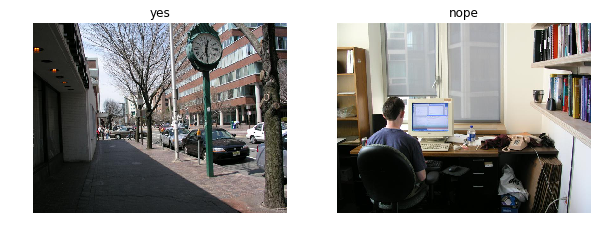

In [41]:
# create one question, positive & negative models
target_synset = 'clock.n.01'

all_vg_img_ids = np.array(list(set(df['vgobjdf']['image_id'].tolist())))

target_present = df['vgobjdf'][df['vgobjdf']['syn'] == target_synset]
target_not_present_img_ids = list(set(all_vg_img_ids) - set(target_present['image_id']))

pick_positive = 10
pick_negative = 20

print "Is there a", target_present.iloc[pick_positive]['name'], '?' # target_synset, "?"

fig, ax = plt.subplots(1,2, figsize=(10,5))

plot_img_ax(config, ax[0], 'visual_genome',
            target_present.iloc[pick_positive]['image_id'], title='yes')
plot_img_ax(config, ax[1], 'visual_genome',
            target_not_present_img_ids[pick_negative], title='nope')

As before, this method is at best highly likely to generate a true negative instance, but it is not guaranteed to do so. Again, we are making a "closed world assumption" where we go from something not being annotated to it indeed not being present. As discussed above, visual genome does seem fairly good in terms of exhaustiveness, but this is a source of noise to be kept in mind. 

#### Relational NPs

Relational NPs as discussed above are characterised by three elements (the relation and its two arguments). Hence, when we use resolved relational expressions, we can use a finer grained notion of negation, by negating the elements of the relation individually (on the type level).

The following shows an example of an image annotated for a particular relation $r(s, o)$, and negative examples created as:

* Whole relation (type) not annotated for image;
* Object of subject type present, but not of object type;
* Object of object type present, but not of subject type;
* Objects of subject and object type present, but not standing in that relation;
* Relation present, but holding between arguments of other types.

Ideally, no type of negative instance should be easier or harder to resolve; if it was, this would be an indication that the resolution of one of the components, or the composition is not working as intended.

In [42]:
# all definitely indefinite region descriptions (starting with "a")
df['vgindef'] = df['vgpregdf'][df['vgpregdf']['phrase'].str.startswith("A") |\
                               df['vgpregdf']['phrase'].str.startswith("a")]

is there a glass on the table ?


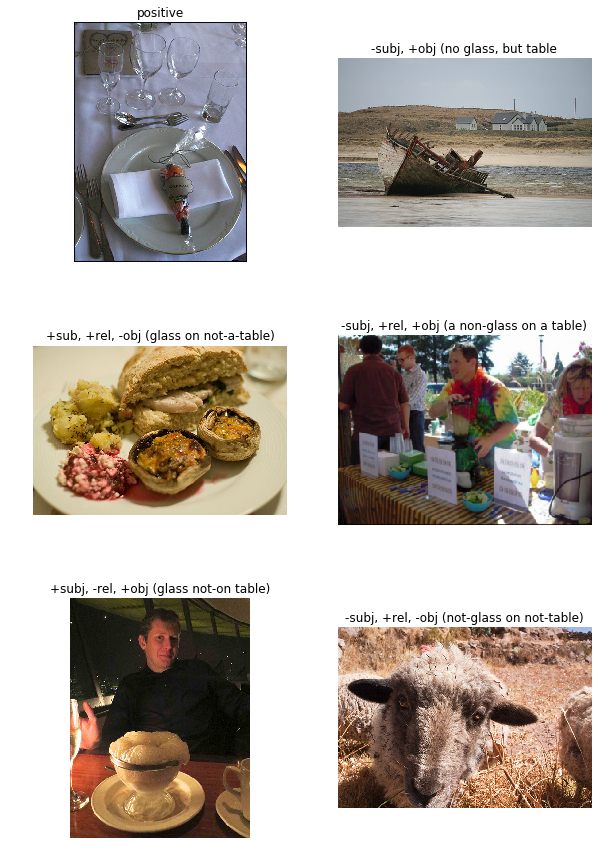

In [43]:
# one question, several (purportedly) negative instances
pick_positive = 251
pick_negative = 30
pos_row = df['vgindef'].iloc[pick_positive]
print 'is there', pos_row['phrase'].lower(), '?'
rel_id = pos_row['rel_ids'][0]
ii = pos_row['image_id']
ssyn, rsyn, osyn = get_rel_type(df['vgreldf'], rel_id)

fig, ax = plt.subplots(3,2, figsize=(10,15))
plot_img_ax(config, ax[0,0], 'visual_genome', ii, title='positive')

# not subj, not obj
ii = get_rel_instances(df['vgreldf'], (ssyn, '*', osyn), ('!=', '*', '!=')).sample()['image_id'].values[0]
plot_img_ax(config, ax[0,1], 'visual_genome', ii, title='-subj, +obj (no glass, but table')

# subj, rel, not obj
ii = get_rel_instances(df['vgreldf'], (ssyn, rsyn, osyn), ('==', '==', '!=')).sample()['image_id'].values[0]
plot_img_ax(config, ax[1,0], 'visual_genome', ii, title='+sub, +rel, -obj (glass on not-a-table)')

# obj, rel, not sub
ii = get_rel_instances(df['vgreldf'], (ssyn, rsyn, osyn), ('!=', '==', '==')).sample()['image_id'].values[0]
plot_img_ax(config, ax[1,1], 'visual_genome', ii, title='-subj, +rel, +obj (a non-glass on a table)')

# subj, obj, not rel
ii = get_rel_instances(df['vgreldf'], (ssyn, rsyn, osyn), ('==', '!=', '==')).sample()['image_id'].values[0]
plot_img_ax(config, ax[2,0], 'visual_genome', ii, title='+subj, -rel, +obj (glass not-on table)')

# rel, not subj, obj
ii = get_rel_instances(df['vgreldf'], (ssyn, rsyn, osyn), ('!=', '==', '!=')).sample()['image_id'].values[0]
plot_img_ax(config, ax[2,1], 'visual_genome', ii, title='-subj, +rel, -obj (not-glass on not-table)')

As these examples illustrate (very likely at least, unless this run of the notebook resulted in a lucky draw), the noisy-ness only increases here (as one has to rely on several elements meaningfully *not* being annotated). 

* **Dataset:** existential "there" questions
* **Negative Instances:** other images, selected for empty denotation of NP
* **Source:** visual genome
* **Uses:** tune confidence of reply

**TODO:** Test first selecting thematically (visually) close images, and selecting from them?

It might also be possible to control this a little bit, by selecting objects that stand in a larger range or relations, to a larger range of other objects. Here, for "glass" as subject, it seems that almost any occurrence will have the glass standing on a table, whether that is annotated or not.

## Situation Descriptions / Captions

We now come to sentence-type expressions that we can directly take from the corpora: *image captions*. While exact explanations of what makes a good caption are not easy to find in the literature, the instructions from COCO give some hints: The annotators were asked to "describe the image" and not to "start the sentence with 'there is'". This shows a crucial difference to the expression types we have previously discussed, in that here the relation is between the expression and the image as a whole.

<!-- The generation of captions is a long-standing task in computer vision (see references in \cite{yueatal:refcoco}), and consequently many data sets with captions exist. Among our selection of corpora, MSCOCO prominently contains them. -->


Here are some example captions from COCO:

In [44]:
# some examples from MSCOCO
for this_cap in df['cococapdf'].sample(5)['caption'].tolist():
    print this_cap

Both a bicycle and a moped are parked near porch steps.
A house with wooden floors and many windows that are open.
a brown white and black dog at the beach with a ball
A cow with an orange tag in its ear.
A group of people a ta long table sharing a meal


As these examples show, syntactically we again find a number of indefinite NPs (which we can extend to sentences using the implicit frame "this is (a picture of) ___"), as well as syntactically complete sentences. To resolve their truth value, one needs to look at the entities in the image and the relations between them.

To evaluate the ability of a model to interpret such sentences (or to train such a model in the first place), we again need negative examples. Here is an example of a randomly drawn image as negative example.

A dog and man with a hat sitting on a bench.


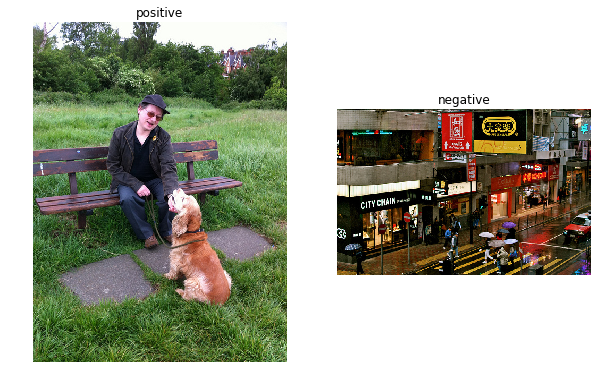

In [45]:
# A caption from COCO, paired with its aligned image and a randomly selected image
pos = df['cococapdf'].sample()
ic, ii, pos_cap = pos['i_corpus image_id caption'.split()].values[0]
neg = df['mscoco_bbdf'].sample()
nii = neg['image_id']

fig, ax = plt.subplots(1,2, figsize=(10, 10))
print pos_cap
plot_img_ax(config, ax[0], 'mscoco', ii, title='positive')
plot_img_ax(config, ax[1], 'mscoco', nii, title='negative')

Randomly selecting an image as negative pairing, however, potentially makes the task too simple. It is quite likely that an image is selected that does not provide an interpretation for *any* of the parts of the sentence, and hence resolution fails already at the stage of resolving NPs.

Ideally, we want to sample the negative example from a set of images that are more *similar* in some respect to the source image (that makes the sentence true). We can now make use of the fact that we can define *similarity relations* between images, and see whether we could generate more challenging negative examples this way.

We define two different similarity relations for this purpose. *Visual* similarity ($sim_{I/I}^{vis}$) is the inverse of the cosine distance in image representation space, using a pre-trained convolutional neural network (here, we used VGG-19, \cite{vgg19}). We compute *content-based* or *semantic* similarity ($sim_{I/I}^{sem}$) by vectorising the image annotation (in a many-hot representation with the object types as dimensions), using SVD to project the resulting matrix into a lower-dimensional space.

Here is an example, showing a caption with its corresponding image, and two distractor images sampled for similarity with it.

A group of women on the subway all using their phones. 


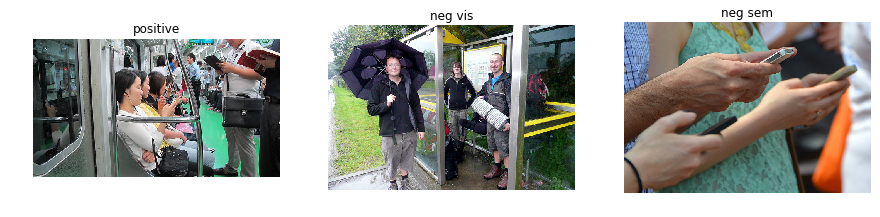

In [46]:
# selecting negative examples based on image similarity
nii = False
while not nii:
    pos = df['cococapdf'].sample()
    ic, ii, pos_cap = pos['i_corpus image_id caption'.split()].values[0]
    if ii in coco_id2semsim and ii in coco_id2vissim:
        neg_sim = n_most_sim(coco_vis_sim, coco_vis_map, coco_id2vissim[ii])
        nii = neg_sim[1]
        negs_sim = n_most_sim(coco_sem_sim, coco_sem_map, coco_id2semsim[ii])
        niis = negs_sim[1]

fig, ax = plt.subplots(1,3, figsize=(15, 15))
print pos_cap
plot_img_ax(config, ax[0], 'mscoco', ii, title='positive')
plot_img_ax(config, ax[1], 'mscoco', nii, title='neg vis')
plot_img_ax(config, ax[2], 'mscoco', niis, title='neg sem')    

As this example shows, instances selected in this way are much more challenging -- to the degree that now it can very well be the case that a caption actually *legitimately* also applies to the image selected as negative example. 

We will come back to this problem presently, but first note that COCO captions do not come with explicit groundings into the image. (That is, the entities mentioned in a caption are not related to bounding boxes in the image; we know, to the extent described above, that the image makes the caption true (or not), but we don't know why.) Flickr30k, another captioned image corpus, gives us such finer grained annotation:

Caption: a girl wearing flip-flop sandals swinging on a swing set in a park underneath
fluffy white clouds .

With groundings:
[/EN#3883/people A girl] wearing [/EN#3889/clothing flip-flop sandals] swinging
on [/EN#3884/other a swing] set in [/EN#3887/scene a park] underneath
[/EN#3890/other fluffy white clouds] .


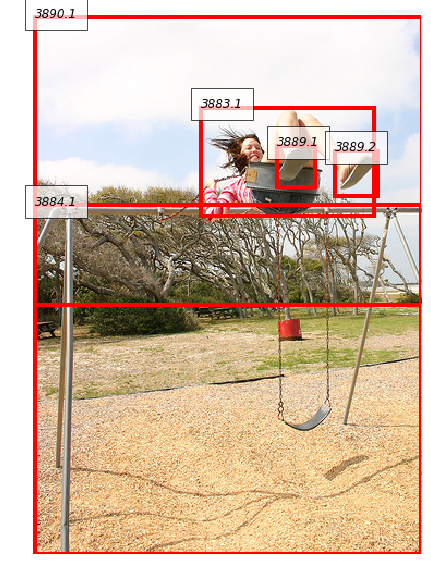

In [47]:
# example of a Flickr30k caption, with a randomly selected negative example
def flcap2bb(cap_row, bbdf):
    cap = cap_row['caption_raw'] # cap_row['caption_annotated']
    entities = cap_row['entities']
    outbb = []
    for entity in entities:
        this_bb = bbdf[bbdf['region_id'] == entity]
        for _, row in this_bb.iterrows():
            outbb.append((row['bb'], '%d.%d' % (entity, row['subregion_id'])))
    # outbb.append(([0,0,10,10], fill(cap, 40)))
    return outbb

pick_row = 2345
this_row = df['flickr_capdf'].iloc[pick_row]
ii = this_row['image_id']
print 'Caption:', fill(this_row['caption_raw'], 80)
print ''
print 'With groundings:\n', fill(this_row['caption_annotated'], 80)
plot_labelled_bb(get_image_filename(config, 8, ii),
                 flcap2bb(this_row, df['flickr_bbdf']), figsize=(10,10))


This corpus comes with sort of the mirror of this problem, however, in that here only those entities are provided with bounding boxes that are mentioned in one of the up to four captions that are available for the image. That is, there is no guarantee that all or even just many objects in the image are segmented and hence available as distractors during interpretation of the constituents of the phrase. This potentially makes the resolution task easier, as there are fewer entities to consider.

We finally note that since visual genome took some of its images from mscoco, there is a subset of images for which both the deep annotation from the latter and the captions from the former are available. This opens up the possibility of deriving a quasi-gold standard grounding for the captions by matching their constituents with the visual genome annotations.

To summarise this part, the task here is to determine whether a given image makes a given caption true or not (or, in more normal phrasing, whether the caption describes the image). For this, the entities mentioned in the caption must be identified in the image and their asserted relationship must be evaluated. 

* **Dataset:** captions
* **Negative Instances:** other images, possibly selected for similarity
* **Source:** COCO, Flickr30kEntities
* **Uses:** evaluate interpretation of complex expressions

## Discourses

Even if formal semantics typically stops at the sentence, we can carry one beyond the sentence level towards *discourses*.

### Image Description Paragraphs

\cite{krauseetal:visgenparas} collected "image paragraphs" for a subset of visual genome. Here is an example of such a paragraph, together with the image that it describes, and two distractor images selected for semantic similarity (see above; similarity of objects annotated in image) and visual similarity. As this shows, judging whether the paragraph fits the image or not (or, in our phrasing, whether the image is a model of the discourse) can be challenging. 

A photo done is a sephia type portrait style of a young man standing with a
model airplane in his hand.  The man appears to be in his late 20's or early
30's with thick dark blond hair.  The man is standing in a residential yard and
is wearing a white, button down shirt and a t shirt under it. He has a wrist
watch on his left arm and is wearing blue jeans.


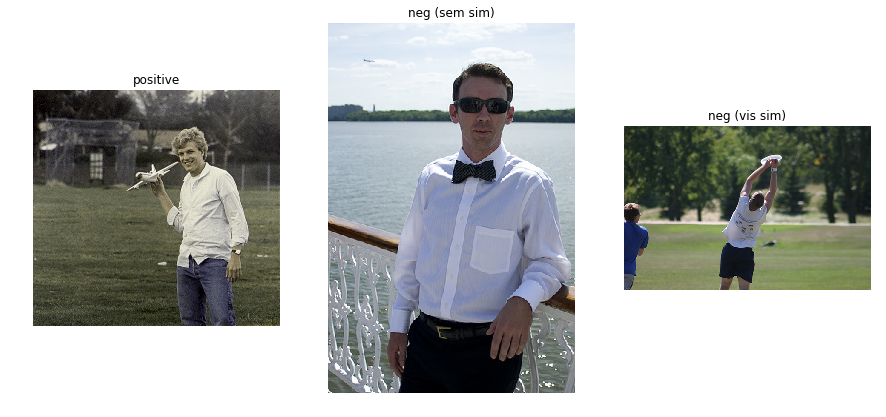

In [48]:
# Example of paragraph & negative examples, selected by semantic and visual similarity
nii = False
while not nii:
    ic, ii, par = df['vgpardf'].sample()['i_corpus image_id paragraph'.split()].values[0]
    if ii in visg_id2semsim and ii in visg_id2vissim:
        nii = n_most_sim(visg_sem_sim, visg_sem_map, visg_id2semsim[ii])[1]
        niis = n_most_sim(visg_vis_sim, visg_vis_map, visg_id2vissim[ii])[1]

    

print fill(par, 80)
_, ax = plt.subplots(1,3, figsize=(15, 15))
plot_img_ax(config, ax[0], 'visual_genome', ii, title="positive")
plot_img_ax(config, ax[1], 'visual_genome', nii, title="neg (sem sim)")
plot_img_ax(config, ax[2], 'visual_genome', niis, title="neg (vis sim)")

As an interpretation task, this dataset does not add anything new: the model simply has to make all the sentences in the discourse true, to make the discourse as a whole true. But it provides further  challenging test cases, on which the accummulation of uncertainty about interpretation can be explored.

In terms of *explanations*, if an image is rejected as not fitting to the paragraph, we can ask which sentence or sentences was or were judged as not fitting.

Furthermore, there are discourse phenomena that need to be taken into account, such as co-reference (definite NPs referring to previously introduced entities). This opens up a new level, that of *discourse semantics* (more on this in a separate notebook).

* **Dataset:** caption paragraphs
* **Negative Instances:** pairing with different image
* **Source:** visual genome
* **Uses:** evaluate interpretation

Technically, we again face the problem here that this annotation comes without groundings (that is, there is no connection to the object bounding boxes). This makes a compositional approach such as sketched above more difficult to set up. In the next section we will hence look at ways to *construct* "discourses" out of the existing grounded annotation. These discourses will be less natural, but to make up for that, they offer more control.

### Sequences of Region Descriptions

The following example shows, for a randomly selected image, all region annotations from visual genome. (And again two distractor images, sampled using our two similarity metrics.) We can look at them as a form of multi-expression discourse about an image.

a dark window on a building
a gray car driving down the street
sign above the window
person wearing a green shirt
a man crossing the street
a black garbage can on the sidewalk
license plate on the front of the black car
light on a pole
white line on the road
 door on a business
woman wearing a sweatshirt around her waist
balcony above the windows on the building
white lines on the crosswalk
 woman in a green shirt crossing the street


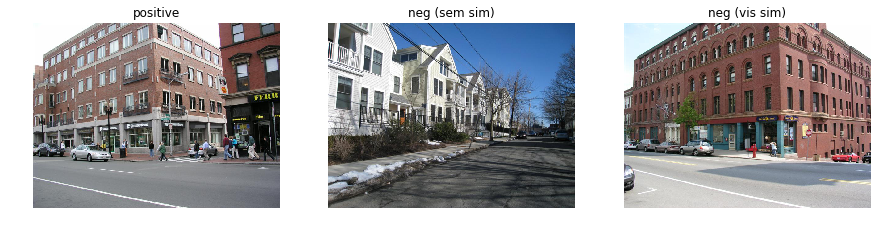

In [49]:
# A "deep caption" / image description paragraph, from visgen region descr.
nii = False
while not nii:
    ic, ii = df['vgpregdf'].sample()[['i_corpus', 'image_id']].values[0]
    if ii in visg_id2semsim and ii in visg_id2vissim:
        nii = n_most_sim(visg_sem_sim, visg_sem_map, visg_id2semsim[ii])[1]
        niis = n_most_sim(visg_vis_sim, visg_vis_map, visg_id2vissim[ii])[1]

all_phrases = df['vgpregdf'][df['vgpregdf']['image_id'] == ii]['phrase'].tolist()
all_phrases = list(set(all_phrases))
for phr in all_phrases:
    print phr

_, ax = plt.subplots(1,3, figsize=(15, 15))
plot_img_ax(config, ax[0], 'visual_genome', ii, title="positive")
plot_img_ax(config, ax[1], 'visual_genome', nii, title="neg (sem sim)")
plot_img_ax(config, ax[2], 'visual_genome', niis, title="neg (vis sim)")

It should be clear from this example that the discourses created in this way are not particularly natural-sounding --- not being created as discourses, they lack constitutive discourse features such as cohesion and coherence relations between sentence. 

However, there is one discourse property that does occur, namely *co-reference* (in a limited form, at least). In most image annotations it will be the case that objects occur in more than one region description, and hence, the expressions referring to them are co-referring. We know whether this is the case through the groundings; the task could be to infer this. (This gets more interesting if we take the image out of the equation; we will discuss this below.) For now, we just note that we can set up the task of determining whether such a "discourse" describes a given image or not.

* **Dataset:** sequence of region descriptions
* **Negative Instances:** pairing with different image
* **Source:** visual genome
* **Uses:** evaluate interpretation

## Conclusions

This concludes our look at the task of computing the denotation of an expression, given an image. We went from the denotations of single words, to those of phrases, to those of sentences (or questions). In other notebooks, we will look at discourse level tasks that go beyond single sentence, and at tasks that tackle *generation*, rather than *interpretation* as here.

We also note here that there have been some recent effort to create datasets with more challenging (and arguably, less natural) descriptions such as "all red squares next to blue circles are smaller than the green square", with the express purpose of challenging the compositionality of the interpretation method  \cite{Andreas2016a}, \cite{Suhr2017}, \cite{Suhr2018}.

# References

[<a id="cit-Rosch1978" href="#call-Rosch1978">1</a>] Eleanor Rosch, ``_Principles of Categorization_'',  1978.

[<a id="cit-schlaetal:imagewac" href="#call-schlaetal:imagewac">2</a>] D. Schlangen, S. Zarrie{\ss} and C. Kennington, ``_Resolving References to Objects in Photographs using the Words-As-Classifiers Model_'', Proceedings of ACL 2016, August 2016.

[<a id="cit-Kazemzadeh2014" href="#call-Kazemzadeh2014">3</a>] S. Kazemzadeh, V. Ordonez, M. Matten <em>et al.</em>, ``_ReferItGame: Referring to Objects in Photographs of Natural Scenes_'', Proceedings of the Conference on Empirical Methods in Natural Language Processing (EMNLP 2014),  2014.

[<a id="cit-yueatal:refcoco" href="#call-yueatal:refcoco">4</a>] L. Yu, P. Poirson, S. Yang <em>et al.</em>, ``_Modeling Context in Referring Expressions_'', Computer Vision – ECCV 2016,  2016.

[<a id="cit-Maoetal:cocorefexp_Final" href="#call-Maoetal:cocorefexp_Final">5</a>] J. Mao, ``_Generation and Comprehension of Unambiguous Object Descriptions_'', Proceedings of CVPR 2016, June 2016.

[<a id="cit-Cirik2018b" href="#call-Cirik2018b">6</a>] V. Cirik, T. Berg-kirkpatrick and L. Morency, ``_Using Syntax to Ground Referring Expressions in Natural Images_'', AAAI 2018,  2018.

[<a id="cit-krishnavisualgenome" href="#call-krishnavisualgenome">7</a>] R. Krishna, Y. Zhu, O. Groth <em>et al.</em>, ``_Visual Genome: Connecting Language and Vision Using Crowdsourced Dense Image Annotations_'', ,  2016.  [online](https://arxiv.org/abs/1602.07332)

[<a id="cit-fellbaum:wordnet" href="#call-fellbaum:wordnet">8</a>] , ``_WordNet: An Electronic Lexical Database_'',  1998.

[<a id="cit-landau_jackendoff_1993" href="#call-landau_jackendoff_1993">9</a>] Landau Barbara and Jackendoff Ray, ``_“What” and “where” in spatial language and spatial cognition_'', Behavioral and Brain Sciences, vol. 16, number 2, pp. 217–238,  1993.

[<a id="cit-ventraldorsal:whatwhere" href="#call-ventraldorsal:whatwhere">10</a>] Leslie G. and Mortimer Mishkin, ``_Two cortical visual systems_'',  1982.

[<a id="cit-Landau2016" href="#call-Landau2016">11</a>] Landau Barbara, ``_Update on “What” and “Where” in Spatial Language: A New Division of Labor for Spatial Terms_'', Cognitive Science, vol. 41, number S2, pp. ,  2017.

[<a id="cit-milljohns:langperc" href="#call-milljohns:langperc">12</a>] G. Miller and Phillip Johnson-Laird, ``_Language and Perception_'',  1976.

[<a id="cit-vgg19" href="#call-vgg19">13</a>] Simonyan Karen, ``_Very Deep Convolutional Networks for Large-Scale Image Recognition_'', CoRR, vol. abs/1409.1556, number , pp. ,  2014.  [online](http://arxiv.org/abs/1409.1556)

[<a id="cit-krauseetal:visgenparas" href="#call-krauseetal:visgenparas">14</a>] J. Krause, J. Johnson, R. Krishna <em>et al.</em>, ``_A hierarchical approach for generating descriptive image paragraphs_'', Proceedings - 30th IEEE Conference on Computer Vision and Pattern Recognition, January 2017.

[<a id="cit-Andreas2016a" href="#call-Andreas2016a">15</a>] J. Andreas, M. Rohrbach, T. Darrell <em>et al.</em>, ``_Neural Module Networks_'', Proceedings of the 2016 Conference on Computer Vision and Pattern Recognition (CVPR 2016),  2016.

[<a id="cit-Suhr2017" href="#call-Suhr2017">16</a>] A. Suhr, M. Lewis, J. Yeh <em>et al.</em>, ``_A Corpus of Natural Language for Visual Reasoning_'', Proceedings of the 2017 meeting of the Association for Computational Linguistics (ACL 2017),  2017.  [online](http://yoavartzi.com/pub/slya-acl.2017.pdf)

[<a id="cit-Suhr2018" href="#call-Suhr2018">17</a>] A. Suhr, S. Zhou, I. Zhang <em>et al.</em>, ``_A Corpus for Reasoning About Natural Language Grounded in Photographs_'', Proceedings of NIPS 2018,  2018.

